## AFDS

In [621]:
from PIL import Image, ImageFilter
import numpy as np
import math
from scipy.sparse import csr_matrix,lil_matrix
import matplotlib.pyplot as plt
import datetime
import copy
%matplotlib inline


In [610]:
t = 0.9
k = 500
size = 100

def wrapAdd(i, p):
    res = i+p
    if res < 0:
        return i+p+size
    if res>=size:
        return i+p-size
    return res

In [611]:
I = Image.open('./bear.png') 
J = I.resize((size,size), resample=Image.LANCZOS)
J = J.filter(ImageFilter.GaussianBlur(radius = 2))
#J.show()
J.save('./q1output.png')
Vc = np.array(J)

In [612]:
print(Vc[20,20])
Vc = Vc/255.0
print(Vc[20,20])
Vi = np.ones([size, size, 2],dtype=np.float64)

for i in range(size):
    for j in range(size):
        Vi[i,j,0] = i/size
        Vi[i,j,1] = j/size       
        
print(Vi[20,20])

V = np.concatenate((Vc, Vi), axis = 2)
print(V[20,20])


[178 201 106]
[0.69803922 0.78823529 0.41568627]
[0.2 0.2]
[0.69803922 0.78823529 0.41568627 0.2        0.2       ]


In [613]:
oldtime=datetime.datetime.now()

W = np.zeros([size*size, size*size],dtype=np.float64)
D = np.zeros(size*size,dtype=np.float64)
A = np.zeros([size*size, size*size],dtype=np.float64)
edgeCnt = 0
weightSum = 0

for i in range(size):
    for j in range(size):
        ind1 = i*size+j
        for p in range(0, 6):
            for q in range(-5, 6):
                if p == 0 and q <= 0:
                    continue
                m = wrapAdd(i, p)
                n = wrapAdd(j, q)
                w = math.exp(-4*((Vc[i,j]-Vc[m,n]).dot(Vc[i,j]-Vc[m,n]) + (p*p+q*q)/(size*size)))
                
                if w > t:
                    ind2 = m*size+n
                    W[ind1, ind2] = w
                    W[ind2, ind1] = w
                    D[ind1] = D[ind1] + w
                    D[ind2] = D[ind2] + w
                    A[ind1, ind2] = 1
                    A[ind2, ind1] = 1
                    edgeCnt = edgeCnt+1
                    weightSum = weightSum + 2 * w
            
weightSum = weightSum/2
print("number of edges:",edgeCnt,"average degree", weightSum/(size*size))    
newtime=datetime.datetime.now()
print((newtime-oldtime))

number of edges: 498337 average degree 48.61045441459484
0:00:03.139855


In [614]:
oldtime=datetime.datetime.now()

D12_v = np.zeros(size*size,dtype=np.float64)
for i in range(size*size):
    if D[i] == 0:
        print(i)
    D12_v[i] = 1/math.sqrt(D[i])
    
ind = np.arange(0,size*size)
D12 = csr_matrix((D12_v, (ind, ind)), shape=[size*size, size*size])
I = csr_matrix((np.ones(size*size), (ind, ind)), shape=[size*size, size*size])
Acsr = csr_matrix(A)
L = I+D12.dot(Acsr).dot(D12)

newtime=datetime.datetime.now()
print((newtime-oldtime))

0:00:01.015768


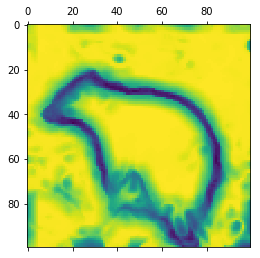

[[2.01953663]]


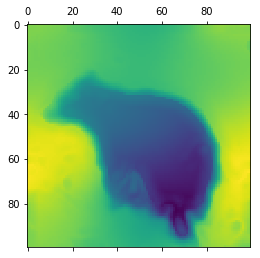

0:00:01.112386


In [615]:
oldtime=datetime.datetime.now()

v1 = np.zeros(size*size)
for i in range(size*size):
    v1[i] = math.sqrt(D[i])
v1 = v1.reshape([size*size, 1])
v1_normalized = v1/np.linalg.norm(v1)
V1 = v1_normalized.reshape(size,size)
plt.matshow(V1)
plt.show()


#Power Method
x=np.random.normal(0, 1, [size*size,1])
x = x - v1_normalized*(x.T).dot(v1_normalized)

for i in range(k):
    x = L.dot(x)

    
x = x/np.linalg.norm(x)
x = x - v1_normalized*(x.T).dot(v1_normalized)
y = L.dot(x)
lambda2 = (y.T.dot(x))/(x.T.dot(x))
print(lambda2)
x = x/np.linalg.norm(x)
X = x.reshape(size,size)
plt.matshow(X)
plt.show()

newtime=datetime.datetime.now()
print((newtime-oldtime))

In [623]:
oldtime=datetime.datetime.now()

my_dtype = [("i", int), ("f", np.float64)]

values = np.zeros(size*size, dtype=my_dtype)
values['i'] = np.arange(0, size*size)
values['f'] = x.T
V_s = np.sort(values, order='f')

newtime=datetime.datetime.now()
print((newtime-oldtime))

0:00:00.013996


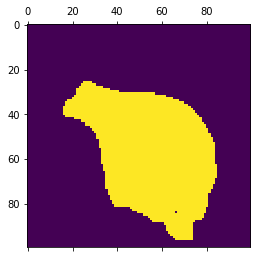

0:00:00.408237


In [636]:
oldtime=datetime.datetime.now()

S1 = np.zeros([10000, 1])
S1[V_s[0]["i"]] = 1
S[V_s[0]["i"]] = 1
w_between = W[V_s[0]["i"],:].sum()
volS = 0
volVS = D.sum()
PHIS1 = w_between
S = np.zeros([10000, 1])
I1 = np.ones([10000, 1])

t = 1
while t < size*size:
    S[V_s[t]["i"]] = 1
    
    W_vector = W[V_s[t]["i"]]
    w_between = w_between - W_vector.dot(S) + W_vector.dot(I1-S)
    volS = volS+D[V_s[t]["i"]]
    volVS = volVS-D[V_s[t]["i"]]
    PHI_value = w_between/min(volS,volVS)
    if PHI_value < PHIS1:
        S1 = copy.deepcopy(S)
        PHIS1 = PHI_value
    t = t+1
        
final = S1.reshape(size,size)
plt.matshow(final)
plt.show()

newtime=datetime.datetime.now()
print((newtime-oldtime))